In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
from numba import jit

In [2]:
#Sobel Img Edge Detection
def edgeImg(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelX = cv2.Sobel(gray,cv2.CV_64F,1,0)
    sobelY = cv2.Sobel(gray,cv2.CV_64F,0,1)

    return np.sqrt(np.power(sobelX,2) + np.power(sobelY,2))

In [3]:
#use dynamic programming to find Min Energy Path
@jit
def calculateMinEnergyPath(energyImg):
    minEnergyPath = np.zeros(energyImg.shape)
    n = energyImg.shape[0]
    m = energyImg.shape[1]

    #base case on the last row of the matrix
    for j in range(0,m):
        minEnergyPath[n-1][j] = energyImg[n-1][j]

    #builds matrix from bottom up
    for i in range(n-2,-1,-1):
        for j in range(0,m):
            #just making sure we dont go out of bounds and finding the min
            left = max(0,j-1)
            right = min(m-1,j+1)
            

            minEnergyPath[i][j] = energyImg[i][j] + min(minEnergyPath[i+1][left:right+1])

    return minEnergyPath

In [4]:
@jit
def removeSeam(img,minEnergyPath):
    n = minEnergyPath.shape[0]
    m = minEnergyPath.shape[1]
    
    minPos = 0
    minVal = minEnergyPath[0][0]

    #find Min Seam
    for i in range(1,m):
        if(minEnergyPath[0][i] < minVal):
            minPos = i
            minVal = minEnergyPath[0][i]

    newImg = np.zeros((img.shape[0],img.shape[1]-1,img.shape[2]),dtype=np.uint8)

    newImg[0] = np.concatenate((img[0][0:minPos],img[0][minPos+1:img.shape[1]]))
    for i in range(1,n):
        #find min from three down
        center = minPos
        min = minEnergyPath[i][center]

        if(center>0 and minEnergyPath[i][center-1] < min):
            min = minEnergyPath[i][center-1]
            minPos = center -1

        if(center<m-1 and minEnergyPath[i][center+1] < min):
            min = minEnergyPath[i][center+1]
            minPos = center+1

        newImg[i] = np.concatenate((img[i][0:minPos],img[i][minPos+1:img.shape[1]]))
    
    return newImg

In [16]:
def removeNSeams(img,seamNumber):
    newImg = img
    for i in range(0,seamNumber):
        #print('removing Seam Number ', i)
        print ('removing seam ',i+1, ' of ', seamNumber, end="\r")
        
        newEP = calculateMinEnergyPath(edgeImg(newImg))
        newImg = removeSeam(newImg,newEP)


    return newImg

## Remoção de Seams Demo

Nessa parte temos uma demo da remoção de Seams da imagem

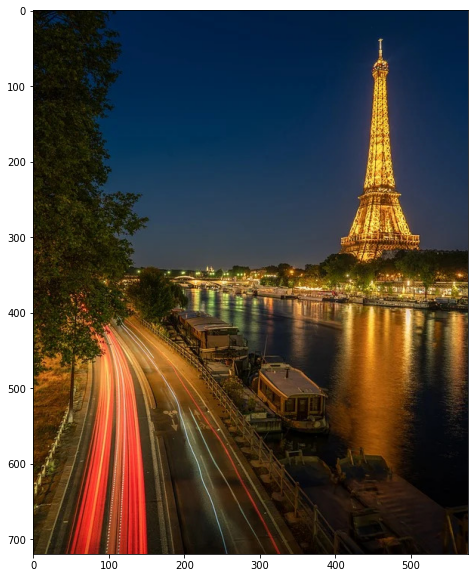

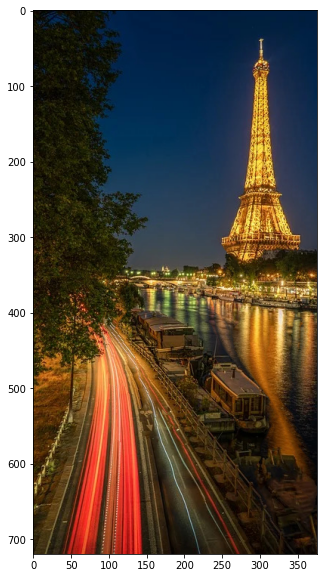

In [15]:
#Aqui basta carregar a imagem que quer aplicar a remoção
img = imageio.imread('imgs/paris.jpg')

newImg = removeNSeams(img,200) #aqui coloque o numero de pixels que quer reduzir

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(newImg)
plt.show()

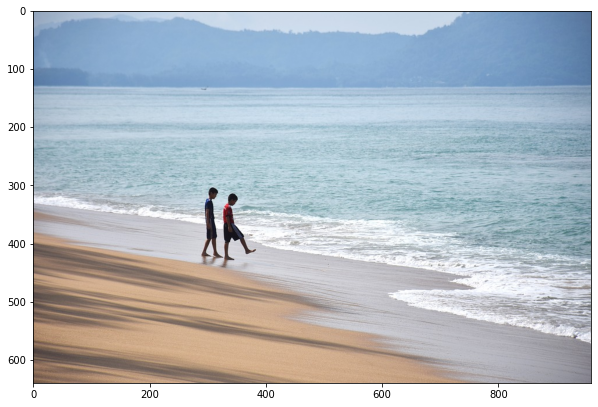

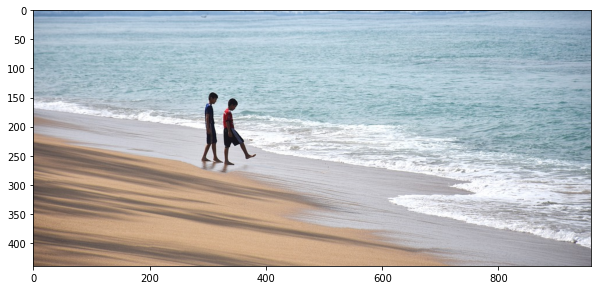

In [18]:
#se quiser remover na horizontal pode fazer assim

img = imageio.imread('imgs/beach2.jpg')

newImg = np.rot90(img)

newImg = removeNSeams(newImg,200) #aqui coloque o numero de pixels que quer reduzir

newImg = np.rot90(newImg,-1)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(newImg)
plt.show()

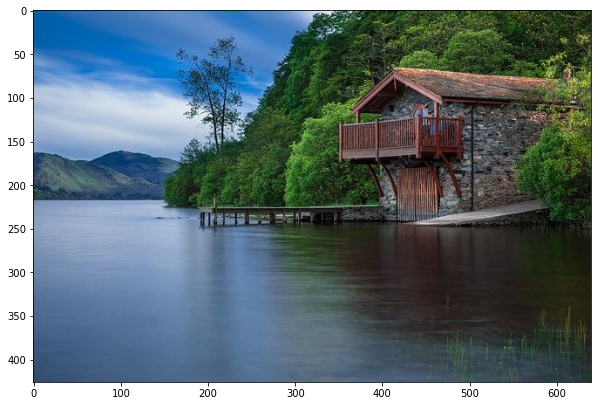

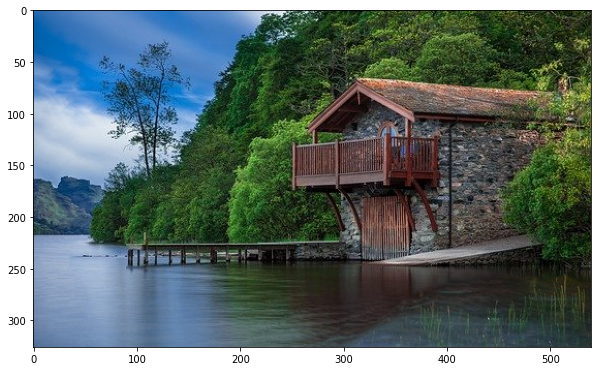

In [32]:
#removendo nos dois eixos

img = imageio.imread('imgs/lake.jpg')

newImg = removeNSeams(img,100) #aqui coloque o numero de pixels que quer reduzir de largura

newImg = np.rot90(newImg)

newImg = removeNSeams(newImg,100) #aqui coloque o numero de pixels que quer reduzir de altura

newImg = np.rot90(newImg,-1)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(newImg)
plt.show()

In [24]:
@jit
def findInsertSeam(img,duplicatePixels,minEnergyPath):
    
    n = img.shape[0]
    m = img.shape[1]
        
    #find path
    minPos = 0
    minVal = minEnergyPath[0][0]
    for i in range(1,m):
        if(minEnergyPath[0][i] < minVal):
            minPos = i
            minVal = minEnergyPath[0][i]

    if(np.isinf(duplicatePixels[0][minPos])): return 1 #error, no more space for insertion

    duplicatePixels[0][minPos] = np.inf

    for i in range(1,n):
        #find min from three down
        center = minPos
        minThree = minEnergyPath[i][center]

        if(center>0 and minEnergyPath[i][center-1] < minThree):
            minThree = minEnergyPath[i][center-1]
            minPos = center -1

        if(center<m-1 and minEnergyPath[i][center+1] < minThree):
            miminThree = minEnergyPath[i][center+1]
            minPos = center+1

        duplicatePixels[i][minPos] = np.inf

    return 0

@jit
def expandImage(img,duplicatePixels):
    #count number of lines to add
    numLine = 0
    for i in range(duplicatePixels.shape[1]):
        if(np.isinf(duplicatePixels[0][i])): numLine += 1
        
    newImg = np.zeros((img.shape[0],img.shape[1]+numLine,img.shape[2]),dtype=np.uint8)
    
    for i in range(img.shape[0]):
        indiceColumNewImage = 0
        for j in range(img.shape[1]):
            newImg[i][indiceColumNewImage] = img[i][j]
            indiceColumNewImage += 1
            if(np.isinf(duplicatePixels[i][j])): #add again if its repeated
                newImg[i][indiceColumNewImage] = img[i][j]
                indiceColumNewImage += 1

    return newImg

def insertNseams(img,N):
    
    duplicatePixels = np.zeros((img.shape[0],img.shape[1])) # saves pixels that will be duplicated
    
    numSeamsInserted = 0
    
    while(numSeamsInserted < N):
        print ('inserting seam ',numSeamsInserted+1, ' of ', N, end="\r")
        minEnergyPath = calculateMinEnergyPath(edgeImg(img)+duplicatePixels)
        if(findInsertSeam(img,duplicatePixels,minEnergyPath) == 1):
            img = expandImage(img,duplicatePixels)
            duplicatePixels = np.zeros((img.shape[0],img.shape[1]))
            continue
        else:
            numSeamsInserted += 1

    newImg = expandImage(img,duplicatePixels)
    return newImg

## Expansão de Imagem Demo

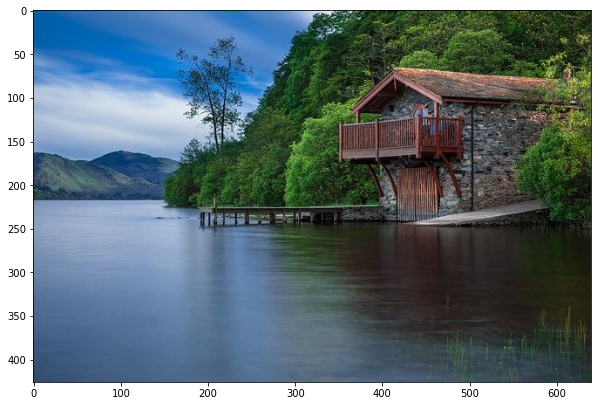

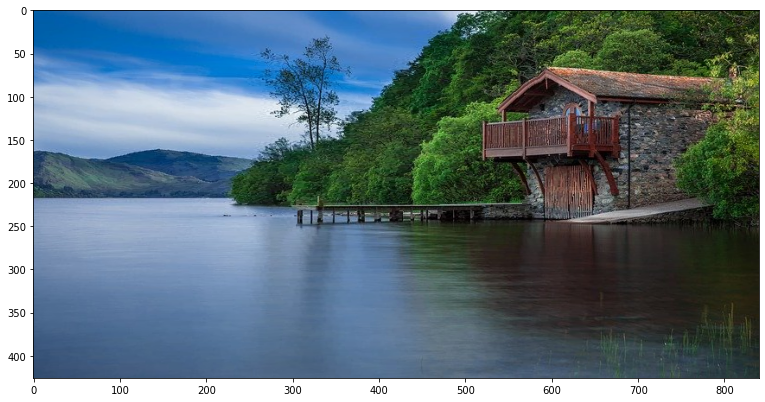

In [27]:
#carrega imagem
img = imageio.imread('imgs/lake.jpg')

#numero de pixels para adicionar na largura, como foi dito no relatorio, podemos fazer apenas uma grande expansao
#ou fazer varias pequenas, em geral é melhor achar um meio termo, aqui vamos fazer 2 de 100 pixels, mas você pode
#variar isso e ver os diferentes resultados
newImg = insertNseams(img,100)
newImg = insertNseams(newImg,100)


plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

plt.figure(figsize=(13,10))
plt.imshow(newImg)
plt.show()

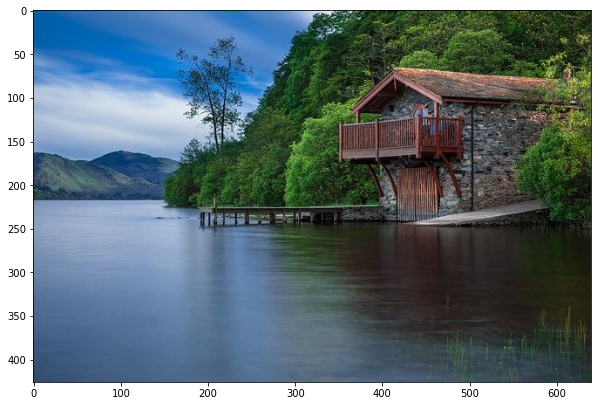

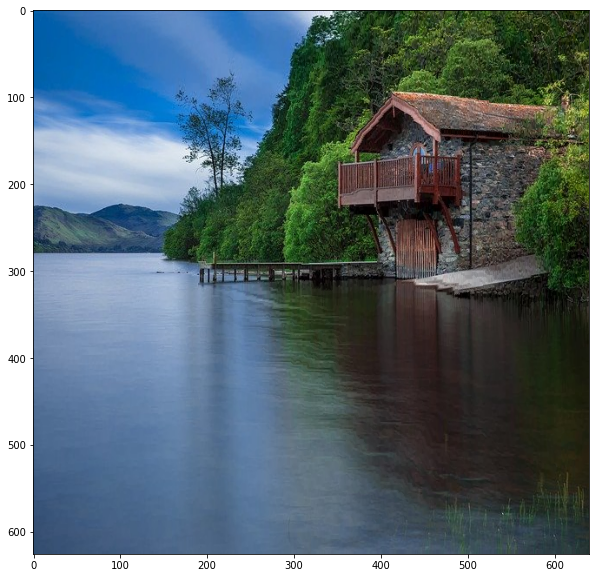

In [28]:
#expandindo na altura
img = imageio.imread('imgs/lake.jpg')

newImg = np.rot90(img)

newImg = insertNseams(newImg,100)
newImg = insertNseams(newImg,100)

newImg = np.rot90(newImg,-1)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

plt.figure(figsize=(13,10))
plt.imshow(newImg)
plt.show()

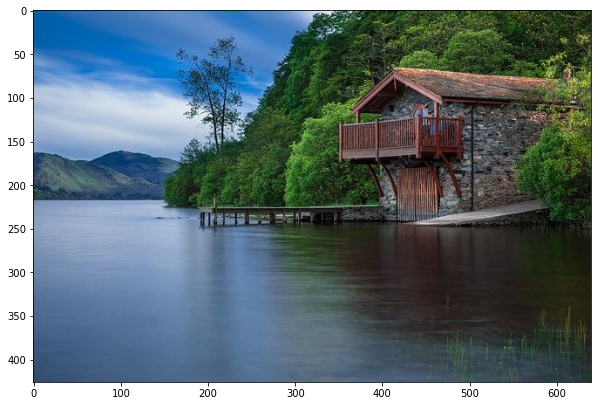

In [29]:
#expandindo nos dois
img = imageio.imread('imgs/lake.jpg')

newImg = insertNseams(img,100)
newImg = insertNseams(newImg,100)

newImg = np.rot90(newImg)

newImg = insertNseams(newImg,100)
newImg = insertNseams(newImg,100)

newImg = np.rot90(newImg,-1)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

plt.figure(figsize=(13,10))
plt.imshow(newImg)
plt.show()

## Uso de mascaras para remoção de Objetos e Manter objetos

In [33]:
@jit
def removeSeamWithMask(img,minEnergyPath,mask):
    n = minEnergyPath.shape[0]
    m = minEnergyPath.shape[1]
    
    minPos = 0
    minVal = minEnergyPath[0][0]

    #find Min Seam
    for i in range(1,m):
        if(minEnergyPath[0][i] < minVal):
            minPos = i
            minVal = minEnergyPath[0][i]

    newImg = np.zeros((img.shape[0],img.shape[1]-1,img.shape[2]),dtype=np.uint8)
    newMask = np.zeros((mask.shape[0],mask.shape[1]-1),dtype=np.double)

    newImg[0] = np.concatenate((img[0][0:minPos],img[0][minPos+1:img.shape[1]]))
    newMask[0] = np.concatenate((mask[0][0:minPos],mask[0][minPos+1:mask.shape[1]]))
    for i in range(1,n):
        #find min from three down
        center = minPos
        min = minEnergyPath[i][center]

        if(center>0 and minEnergyPath[i][center-1] < min):
            min = minEnergyPath[i][center-1]
            minPos = center -1

        if(center<m-1 and minEnergyPath[i][center+1] < min):
            min = minEnergyPath[i][center+1]
            minPos = center+1

        newImg[i] = np.concatenate((img[i][0:minPos],img[i][minPos+1:img.shape[1]]))
        newMask[i] = np.concatenate((mask[i][0:minPos],mask[i][minPos+1:mask.shape[1]]))
    
    return newImg,newMask

In [34]:
def removeNSeamsWithMask(img,seamNumber,mask):
    newImg = img
    newMask = mask
    for i in range(0,seamNumber):
        #print('removing Seam Number ', i)
        print ('removing seam ',i+1, ' of ', seamNumber, end="\r")
        edge = edgeImg(newImg)
        edge[np.where(newMask == -1)] = -10000
        edge[np.where(newMask == 1)] = np.inf
        newEP = calculateMinEnergyPath(edge)
        newImg,newMask = removeSeamWithMask(newImg,newEP,newMask)

    return newImg,newMask

In [38]:
drawing = False # true if mouse is pressed
def drawMask(img,size):
    mask = np.zeros(img.shape[0:2],dtype=np.double)
    
    value = -1
    ix,iy = -1,-1
    # mouse callback function
    def draw_circle(event,x,y,flags,param):
        global ix,iy,drawing,mode
        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            ix,iy = x,y
        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing == True:
                cv2.circle(mask,(x,y),size,value,-1)
        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False

    # Create a black image, a window and bind the function to window
    cv2.namedWindow('image')
    cv2.setMouseCallback('image',draw_circle)
    while(1):
        imgMod = np.copy(img)
        imgMod[np.where(mask == -1)] = (255,0,0)
        imgMod[np.where(mask == 1)] = (0,255,0)
        cv2.imshow('image',cv2.cvtColor(imgMod, cv2.COLOR_RGB2BGR))
        key = cv2.waitKey(20) & 0xFF
        if key == ord("q"):
            break
        
        if key == ord("e"):
            value = 0
        if key == ord("i"):
            value = 1
        if key == ord("d"):
            value = -1
            
        elif key == 27:
            break
    cv2.destroyAllWindows()
    return mask

In [41]:
#imagem a ser selecionada
img = imageio.imread('imgs/Beach.png')

#aqui ele pedira para voce desenhar a mascara com seu mouse
#os controles são
# left click para pintar
# d - seleciona brush que pinta area a ser removida
# e - seleciona borracha para apagar areas pintadas
# q - termina de pintar seleção e fecha janela
mask = drawMask(img,5) 

newImg, newMask = removeNSeamsWithMask(img,200,mask) # aqui voce passa o quanto voce quer remover de largura

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(newImg)
plt.show()

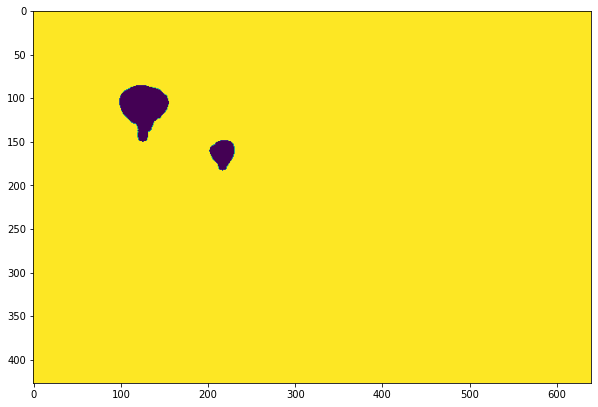

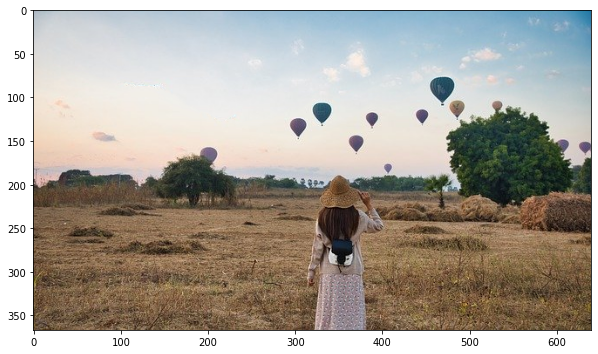

In [47]:
img = imageio.imread('imgs/ballon.jpg')

mask = drawMask(img,5) 

#para remover na horizontal basta rotacionar mascara e imagem
newMask = np.rot90(mask)
newImg = np.rot90(img)

newImg, newMask = removeNSeamsWithMask(newImg,60,newMask) # aqui voce passa o quanto voce quer remover de largura

newImg = np.rot90(newImg,-1)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(newImg)
plt.show()

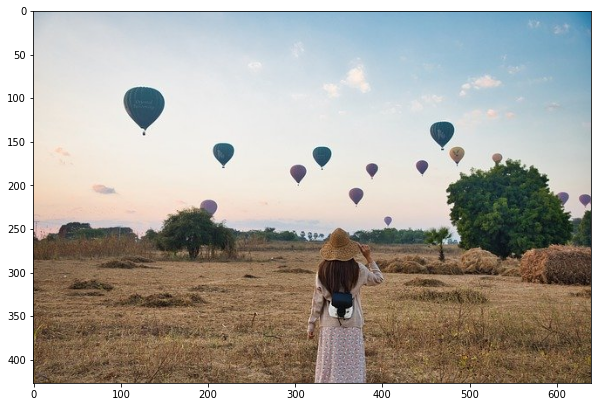

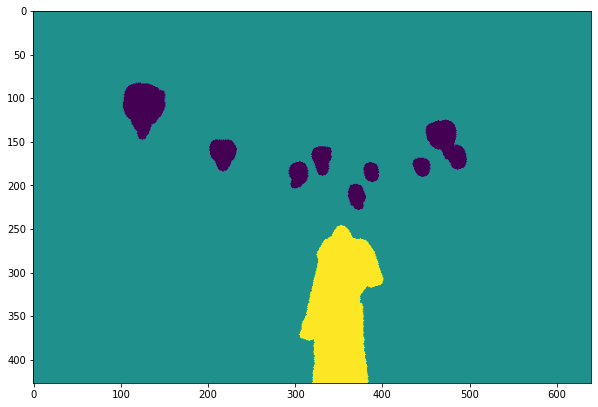

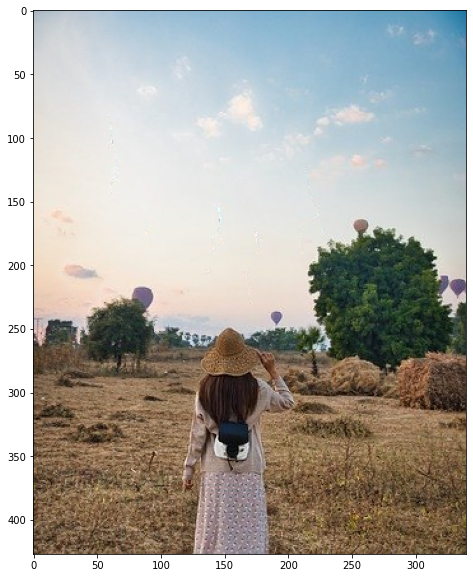

In [49]:
#por ultimo podemos tambem aplicar uma mascara para evitar deformar objetos
img = imageio.imread('imgs/ballon.jpg')

#alem dos comando anteriores é possivel utilizar a brush de manter objetos
# i - brush de manter objetos
mask = drawMask(img,5) 

newImg, newMask = removeNSeamsWithMask(img,300,mask)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(newImg)
plt.show()

In [ ]:
#é possivel aplicar essa mascara tambem na redução de imagens sem a remoção de objetos se o algoritmo estiver
#alterando a forma de algum objeto da cena que não queria que alterasse